In [1]:
!pip install dgl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 51.7 MB/s eta 0:00:0000:0100:01


In [2]:
!pip install geoopt
!pip install geomstats
!pip install dgl
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 65.3 MB/s eta 0:00:00:00:01:01


In [3]:
!pip install ogb

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.9 MB/s eta 0:00:00
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7026 sha256=c46f10b5b4b9f2f59c28cfb951624dd98bb457285d72f9c88716d2e2d8adf711
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [4]:
import logging
import matplotlib.pyplot as plt

import geomstats.backend as gs
import geomstats.visualization as visualization

from geomstats.datasets.utils import load_karate_graph
from geomstats.geometry.poincare_ball import PoincareBall

In [5]:
import random
import numpy as np
import torch
import dgl.data

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


### Load the Dataset

In [6]:
# import dgl
# from dgl.data import CoraGraphDataset
# cora_dataset = CoraGraphDataset()
# cora_ml = cora_dataset[0]

creating dictionary to identify class type- for semantics

* class:3---- Neural network
* class:4---- Probabilistic methods
* class:2---- Genetic Algorithms
* class:0---- Theory
* class:5---- Case based
* class:1---- Reinforcement learning
* class:6---- Rule learning

In [7]:
import dgl
import torch
from ogb.nodeproppred import DglNodePropPredDataset


# Load the dataset
dataset_arxiv = DglNodePropPredDataset(name='ogbn-arxiv')

# Get the graph and labels
graph_arxiv, labels_arxiv = dataset_arxiv[0]

# Print out some basic information about the dataset
print('Number of nodes:', graph_arxiv.number_of_nodes())
print('Number of edges:', graph_arxiv.number_of_edges())
print('Number of classes:', dataset_arxiv.num_classes)


Downloaded 0.08 GB: 100%|██████████| 81/81 [00:01<00:00, 46.54it/s]


Extracting dataset/arxiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 6710.89it/s]


Converting graphs into DGL objects...


100%|██████████| 1/1 [00:00<00:00, 18.80it/s]

Saving...


Number of nodes: 169343
Number of edges: 1166243
Number of classes: 40


In [8]:
graph_arxiv.ndata['feat'].shape
labels_arxiv.shape

torch.Size([169343, 1])

In [9]:
import numpy as np

# Assuming labels_arxiv is a NumPy array
unique_elements, counts = np.unique(labels_arxiv, return_counts=True)
print(dict(zip(unique_elements, counts)))

{0: 565, 1: 687, 2: 4839, 3: 2080, 4: 5862, 5: 4958, 6: 1618, 7: 589, 8: 6232, 9: 2820, 10: 7869, 11: 750, 12: 29, 13: 2358, 14: 597, 15: 403, 16: 27321, 17: 515, 18: 749, 19: 2877, 20: 2076, 21: 393, 22: 1903, 23: 2834, 24: 22187, 25: 1257, 26: 4605, 27: 4801, 28: 21406, 29: 416, 30: 11814, 31: 2828, 32: 411, 33: 1271, 34: 7867, 35: 127, 36: 3524, 37: 2369, 38: 1507, 39: 2029}


In [10]:
import pandas as pd

# Read the label counts
label_counts = pd.read_csv('/kaggle/input/ogbn-arxiv/raw/node-label.csv').value_counts()
label_counts = label_counts.rename('counts')
label_counts = pd.DataFrame(label_counts)

# Read the label category mapping
label_cat = pd.read_csv('/kaggle/input/ogbn-arxiv/mapping/labelidx2arxivcategeory.csv')

# Merge based on index of label_counts and 'label_index' column of label_cat
merged_df = pd.merge(label_counts, label_cat, left_index=True, right_on='label idx')

# Sort the merged DataFrame by 'label idx' in ascending order
merged_df_sorted = merged_df.sort_values(by='label idx')

# Print the sorted DataFrame
print(merged_df_sorted)

    counts  label idx arxiv category
0      565          0    arxiv cs na
1      687          1    arxiv cs mm
2     4839          2    arxiv cs lo
3     2080          3    arxiv cs cy
4     5861          4    arxiv cs cr
5     4958          5    arxiv cs dc
6     1618          6    arxiv cs hc
7      589          7    arxiv cs ce
8     6232          8    arxiv cs ni
9     2820          9    arxiv cs cc
10    7869         10    arxiv cs ai
11     750         11    arxiv cs ma
12      29         12    arxiv cs gl
13    2358         13    arxiv cs ne
14     597         14    arxiv cs sc
15     403         15    arxiv cs ar
16   27321         16    arxiv cs cv
17     515         17    arxiv cs gr
18     749         18    arxiv cs et
19    2877         19    arxiv cs sy
20    2076         20    arxiv cs cg
21     393         21    arxiv cs oh
22    1903         22    arxiv cs pl
23    2834         23    arxiv cs se
24   22187         24    arxiv cs lg
25    1257         25    arxiv cs sd
2

In [11]:
graph_arxiv.ndata['label'] = labels_arxiv
print(type(graph_arxiv.ndata['label']))

<class 'torch.Tensor'>


In [12]:
label_cat['arxiv category'].to_dict()

{0: 'arxiv cs na',
 1: 'arxiv cs mm',
 2: 'arxiv cs lo',
 3: 'arxiv cs cy',
 4: 'arxiv cs cr',
 5: 'arxiv cs dc',
 6: 'arxiv cs hc',
 7: 'arxiv cs ce',
 8: 'arxiv cs ni',
 9: 'arxiv cs cc',
 10: 'arxiv cs ai',
 11: 'arxiv cs ma',
 12: 'arxiv cs gl',
 13: 'arxiv cs ne',
 14: 'arxiv cs sc',
 15: 'arxiv cs ar',
 16: 'arxiv cs cv',
 17: 'arxiv cs gr',
 18: 'arxiv cs et',
 19: 'arxiv cs sy',
 20: 'arxiv cs cg',
 21: 'arxiv cs oh',
 22: 'arxiv cs pl',
 23: 'arxiv cs se',
 24: 'arxiv cs lg',
 25: 'arxiv cs sd',
 26: 'arxiv cs si',
 27: 'arxiv cs ro',
 28: 'arxiv cs it',
 29: 'arxiv cs pf',
 30: 'arxiv cs cl',
 31: 'arxiv cs ir',
 32: 'arxiv cs ms',
 33: 'arxiv cs fl',
 34: 'arxiv cs ds',
 35: 'arxiv cs os',
 36: 'arxiv cs gt',
 37: 'arxiv cs db',
 38: 'arxiv cs dl',
 39: 'arxiv cs dm'}

In [13]:
import torch

# Assuming graph_arxiv.ndata['label'] is your tensor
graph_arxiv.ndata['label'] = graph_arxiv.ndata['label'].squeeze()

# Now label_tensor is a 1-dimensional tensor
print(graph_arxiv.ndata['label'])


tensor([ 4,  5, 28,  ..., 10,  4,  1])


In [14]:
import torch
import numpy as np
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import torch.nn.functional as F
def generate_semantic_embeddings(class_names_dict, embedding_dim= 512):
    # Tokenize class names
    tokenized_class_names = [word_tokenize(class_name.lower()) for class_name in class_names_dict.values()]
    
    # Train Word2Vec model
    model = Word2Vec(sentences=tokenized_class_names, vector_size = embedding_dim, window=5, min_count=1, workers=40)
    
    # Access the learned embeddings
    label_embeddings = {label: torch.tensor(model.wv[label]) for label, class_name in class_names_dict.items()}
    
    return label_embeddings


# Example usage:
class_names_dict = {0: 'arxiv cs na',
 1: 'arxiv cs mm',
 2: 'arxiv cs lo',
 3: 'arxiv cs cy',
 4: 'arxiv cs cr',
 5: 'arxiv cs dc',
 6: 'arxiv cs hc',
 7: 'arxiv cs ce',
 8: 'arxiv cs ni',
 9: 'arxiv cs cc',
 10: 'arxiv cs ai',
 11: 'arxiv cs ma',
 12: 'arxiv cs gl',
 13: 'arxiv cs ne',
 14: 'arxiv cs sc',
 15: 'arxiv cs ar',
 16: 'arxiv cs cv',
 17: 'arxiv cs gr',
 18: 'arxiv cs et',
 19: 'arxiv cs sy',
 20: 'arxiv cs cg',
 21: 'arxiv cs oh',
 22: 'arxiv cs pl',
 23: 'arxiv cs se',
 24: 'arxiv cs lg',
 25: 'arxiv cs sd',
 26: 'arxiv cs si',
 27: 'arxiv cs ro',
 28: 'arxiv cs it',
 29: 'arxiv cs pf',
 30: 'arxiv cs cl',
 31: 'arxiv cs ir',
 32: 'arxiv cs ms',
 33: 'arxiv cs fl',
 34: 'arxiv cs ds',
 35: 'arxiv cs os',
 36: 'arxiv cs gt',
 37: 'arxiv cs db',
 38: 'arxiv cs dl',
 39: 'arxiv cs dm'}
semantic_embeddings = generate_semantic_embeddings(class_names_dict)


In [15]:
# import dgl
# from dgl.data import CoraGraphDataset

# # Load the Cora dataset
# cora_dataset = CoraGraphDataset()
# cora_ml = cora_dataset[0]

# # Get the labels (classes) for each node
# labels = cora_ml.ndata['label']

# # Initialize an empty dictionary to store class occurrences
# class_distribution = {}

# # Count occurrences of each class label
# for label in labels:
#     if label.item() in class_distribution:
#         class_distribution[label.item()] += 1
#     else:
#         class_distribution[label.item()] = 1

# # Print class distribution dictionary
# print(class_distribution)


In [16]:
import dgl
from dgl.data import CoraFull

# Load the Cora-Full dataset
cora_full_dataset = CoraFull()
cora_full = cora_full_dataset[0]

/opt/conda/lib/python3.10/site-packages/dgl/data/utils.py:377: UserWarning: Class CoraFull will be deprecated, please use CoraFullDataset instead.
  warnings.warn(


/root/.dgl/cora_full.zip:   0%|          | 0.00/6.15M [00:00<?, ?B/s]

Extracting file to /root/.dgl/cora_full_659794fa


### The framework starts here:
1. First sample the base graph
2. the problem encounter is a n-way, k-shot. Thus, we enact the same for the base graph
3. Perform base-training: Episodic learning
4. Save the best model
5. Perform Fine-tuning for new-streams of data

Load the necessary values for the framework

In [17]:
Original_graph = graph_arxiv   #DGL object
base_classes_graph = 10
num_support_base = 10
num_query_base = 10
start_seed_base = 100
num_episodes_base = 300
graph_feats_size = Original_graph.ndata['feat'].shape[1]
n_seed = 42



fixed_list = [52, 46, 11, 24, 52, 70, 66, 41, 162, 1110]
starting_seeds = [425, 310, 20,180, 535, 110, 195, 233, 541, 945]
"""
meta_lr = 0.00001
"""


'\nmeta_lr = 0.00001\n'

In [18]:
# break

### Sample the graph with only required number of classes: For Cora, we have started with 5 classes. The classes are chosen randomly

In [19]:
import dgl
import numpy as np

def process_graph(graph, num_classes_to_keep, random_seed=None, remaining_classes=None):
    # Fix the random seed
    if random_seed is not None:
        np.random.seed(random_seed)

    # Step 1: Identify the number of classes in the graph
    num_classes = len(np.unique(graph.ndata['label'].numpy()))

    # Step 2: Validate the given number of classes to keep
    if not 0 < num_classes_to_keep <= num_classes:
        raise ValueError("Invalid number of classes to keep.")

    # Step 3: Initialize remaining classes if not provided
    if remaining_classes is None:
        remaining_classes = set(range(num_classes))

    # Step 4: Sample classes without replacement until all classes are exhausted
    if len(remaining_classes) < num_classes_to_keep:
        raise ValueError("Not enough remaining classes to sample.")

    p_classes = np.random.choice(list(remaining_classes), size=num_classes_to_keep, replace=False)
    remaining_classes -= set(p_classes)

    # Step 5: Sample nodes corresponding to the specified classes without replacement
    p_nodes = [i for i in range(graph.number_of_nodes()) if graph.ndata['label'][i].item() in p_classes]
    sampled_graph = dgl.node_subgraph(graph, p_nodes)

    # Step 6: Extract node labels and features corresponding to sampled nodes
    sampled_labels = sampled_graph.ndata['label']
    sampled_features = graph.ndata['feat'][p_nodes]  # Replace 'feat' with the actual feature name

    # Step 7: Set the features for the sampled graph
    sampled_graph.ndata['feat'] = sampled_features

    # Step 8: Create a new DGL graph object with sampled features and labels
    new_graph = dgl.graph((sampled_graph.edges()[0], sampled_graph.edges()[1]), num_nodes=sampled_graph.number_of_nodes())
    new_graph.ndata['label'] = sampled_labels
    new_graph.ndata['feat'] = sampled_features  # Replace 'feat' with the actual feature name

    return new_graph, remaining_classes

In [20]:
def get_unique_classes(graph):
    """
    Extracts unique class labels from the 'label' attribute of a graph's node data.

    Parameters:
    - graph: The input graph.

    Returns:
    - list_of_classes: A list of unique class labels.
    """
    try:
        # Assuming 'label' is a tensor or NumPy array
        class_labels = graph.ndata['label'].numpy()
    except KeyError:
        # Adjust the key if the attribute name is different
        print("Error: 'label' attribute not found in node data.")
        return []

    # Extract unique class labels
    unique_classes = set(class_labels)

    # Convert the set to a list (order not guaranteed)
    list_of_classes = list(unique_classes)

    return list_of_classes

In [21]:

# Example usage:
base_remaining_classes = set(range(len(np.unique(Original_graph.ndata['label'].numpy()))))  # Start with all classes

# Sample a subgraph with 20 classes from the base graph
sampled_graph_base, _ = process_graph(
    Original_graph,
    num_classes_to_keep= base_classes_graph,
    random_seed = 42,
    remaining_classes=base_remaining_classes
)
print(f'Base graph classes: {get_unique_classes(sampled_graph_base)}')

Base graph classes: [4, 37, 6, 39, 12, 15, 16, 19, 26, 27]


### Meta-Data generator: we divide the graph into tasks; Each task is further divided into train and test set

In [22]:
import random
import numpy as np
import torch
import dgl.data

class MetaDataGenerator:
    def __init__(self, dataset, num_tasks, num_classes, num_support, num_query, task_random_seeds, random_seeds, num_walks, walk_length):
        self.dataset = dataset
        self.num_tasks = num_tasks
        self.num_classes = num_classes
        self.num_support = num_support
        self.num_query = num_query
        self.task_random_seeds = task_random_seeds
        self.random_seeds = random_seeds
        self.num_walks = num_walks
        self.walk_length = walk_length
        self.task_data = []

    def set_random_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

    def create_task(self, seed, task_random_seeds):
        tasks = []
        edge_indices_train_list = []
        edge_indices_test_list = []
        support_random_walks_list = []
        query_random_walks_list = []

        for task_seed in task_random_seeds:
            self.set_random_seed(task_seed)
            task = {}
            support_set = []
            query_set = []

            unique_classes = np.unique(self.dataset.ndata['label'].numpy())
            class_group = np.random.choice(unique_classes, self.num_classes, replace=False)

            for c in class_group:
                indices = np.where(self.dataset.ndata['label'].numpy() == c)[0]
                support_indices = np.random.choice(indices, size=self.num_support, replace=False)
                query_indices = np.random.choice(indices, size=self.num_query, replace=False)

                support_set.extend(support_indices)
                query_set.extend(query_indices)

            support_random_walks = self.generate_random_walks(support_set)
            support_random_walks_list.append(support_random_walks)

            query_random_walks = self.generate_random_walks(query_set)
            query_random_walks_list.append(query_random_walks)

            # Include query nodes and nodes from query random walks in the 'test' set
            test_set = list(set(query_set + [node for walk in query_random_walks for node in walk]))
            task['test'] = test_set

            train_set = list(set(support_set + [node for walk in support_random_walks for node in walk]))
            task['train'] = train_set
            task['query_set'] = query_set
            task['support_set'] = support_set
            task['seed'] = task_seed

            tasks.append(task)

            # Generate edge indices for the combined set of query nodes and nodes from query random walks
            edge_indices_test = self.get_edges_from_nodes(test_set)
            edge_indices_train = self.get_edges_from_nodes(train_set)

            edge_indices_test_list.append(edge_indices_test)
            edge_indices_train_list.append(edge_indices_train)

        return tasks, edge_indices_train_list, edge_indices_test_list, support_random_walks_list, query_random_walks_list

    def generate_random_walks(self, nodes):
        random_walks = []

        for node in nodes:
            for _ in range(self.num_walks):
                current_node = node
                walk = [current_node]
                for _ in range(self.walk_length - 1):
                    neighbors = list(self.dataset.successors(current_node).numpy())
                    if len(neighbors) > 0:
                        current_node = random.choice(neighbors)
                        walk.append(current_node)
                    else:
                        break
                random_walks.append(walk)

        return random_walks

    def get_edges_from_nodes(self, nodes):
        src, dst = [], []
        for node in nodes:
            successors = list(self.dataset.successors(node).numpy())
            for successor in successors:
                src.append(node)
                dst.append(successor)

        edge_index = torch.stack([torch.tensor(src), torch.tensor(dst)], dim=0).long()
        return edge_index

    def generate_tasks(self):
        tasks = []
        edge_indices_train_list = []
        edge_indices_test_list = []
        support_random_walks_list = []
        query_random_walks_list = []


        for seed in self.random_seeds:
            tasks_data, edges_train, edges_test, support_walks, query_walks = self.create_task(seed, self.task_random_seeds)
            tasks.extend(tasks_data)
            edge_indices_train_list.extend(edges_train)
            edge_indices_test_list.extend(edges_test)
            support_random_walks_list.extend(support_walks)
            query_random_walks_list.extend(query_walks)



        return tasks, edge_indices_train_list, edge_indices_test_list, support_random_walks_list, query_random_walks_list


### Once the tasks are generated and nodes are assigned to respective tasks we extract the features and labels accordingly

In [23]:
import torch
import dgl

def create_feature_label_extractor(graph, tasks):
    def feature_label_extractor(task_id, seed):
        task = tasks[task_id]

        train_set = task['train']
        test_set = task['test']
        support_set = task['support_set']  # Include support set
        query_set = task['query_set']  # Include query set

        # Extract features and labels for the entire graph
        all_features = graph.ndata['feat']
        all_labels = graph.ndata['label']

        # Extract features and labels for the train set
        train_features = all_features[train_set]
        train_labels = all_labels[train_set]

        # Extract features and labels for the test set
        test_features = all_features[test_set]
        test_labels = all_labels[test_set]

        # Extract features and labels for the support set
        support_features = all_features[support_set]
        support_labels = all_labels[support_set]

        # Extract features and labels for the query set
        query_features = all_features[query_set]
        query_labels = all_labels[query_set]

        # Calculate the degrees of nodes
        train_degrees = graph.in_degrees(train_set)
        test_degrees = graph.in_degrees(test_set)
        support_degrees = graph.in_degrees(support_set)
        query_degrees = graph.in_degrees(query_set)

        return (
            torch.tensor(train_features), torch.tensor(train_labels),
            torch.tensor(test_features), torch.tensor(test_labels),
            torch.tensor(support_features), torch.tensor(support_labels),
            torch.tensor(query_features), torch.tensor(query_labels),
            torch.tensor(train_degrees), torch.tensor(test_degrees),
            torch.tensor(support_degrees), torch.tensor(query_degrees)
        )

    return feature_label_extractor


In [24]:
import torch

def reindex_nodes(task_id, train_set_list, edge_indices_list, random_walks_list):
    # Extracting task-specific data
    train_set = train_set_list[task_id]
    src_train, dst_train = edge_indices_list[task_id]  # Assuming edge_indices_list is a list of tensors
    random_walks_train = random_walks_list[task_id]

    # Reindexing nodes in train_set
    node_mapping = {old_node: new_node for new_node, old_node in enumerate(train_set)}
    reindexed_train_set = [node_mapping[node] for node in train_set]

    # Reindexing nodes in edge_indices
    reindexed_edge_indices = torch.stack([
        torch.tensor([node_mapping.get(int(source), -1) for source in src_train], dtype=torch.long),
        torch.tensor([node_mapping.get(int(destination), -1) for destination in dst_train], dtype=torch.long)
    ], dim=0)

    # Filter out rows with missing nodes
    mask = (reindexed_edge_indices != -1).all(dim=0)
    reindexed_edge_indices = reindexed_edge_indices[:, mask]

    # Reindexing nodes in random_walks
    reindexed_random_walks = [
        [node_mapping.get(int(node), -1) for node in walk]
        for walk in random_walks_train
    ]

    # Filter out walks with missing nodes
    reindexed_random_walks = [walk for walk in reindexed_random_walks if -1 not in walk]

    # Create a dictionary for old to new node indices
    old_to_new_mapping = {old_node: new_node for old_node, new_node in node_mapping.items()}

    return reindexed_train_set, reindexed_edge_indices, reindexed_random_walks, old_to_new_mapping

In [25]:
def dict_for_custom_loss_function(reindexed_random_walks, old_to_new_mapping_train, graph):
    original_first_node_list = []
    remaining_nodes = []
    all_firsts = []

    for walks in reindexed_random_walks:
        reindexed_first_node = walks[0]
        all_firsts.append(reindexed_first_node)
        reindexed_remaining_nodes = walks[1:]
        #print(reindexed_remaining_nodes)

        # Find the corresponding original node index using the original-to-reindexed mapping
        original_first_node = next((old_node for old_node, new_node in old_to_new_mapping_train.items() if reindexed_first_node == new_node), None)
        original_first_node_list.append(original_first_node)
        remaining_nodes.append(reindexed_remaining_nodes)


    # Assuming original_labels is a dictionary with node indices as keys and labels as values
    labels_for_nodes = [graph.ndata['label'][node] for node in original_first_node_list if node is not None]

    return labels_for_nodes, remaining_nodes, original_first_node_list, all_firsts

In [26]:
def create_label_dict(labels_for_nodes, remaining_nodes, all_firsts):
    final_list = []
    for i in range(len(labels_for_nodes)):
        final = [labels_for_nodes[i], remaining_nodes[i]]
        final_list.append(final)

    label_dict = {}
    for item in final_list:
        label = item[0].item()  # Convert tensor label to integer
        nodes_list = item[1]


        if label not in label_dict:
            label_dict[label] = nodes_list
        else:
            label_dict[label].extend(nodes_list)



    # Perform set operation to remove duplicates within each list
    for key in label_dict:
        label_dict[key] = list(set(label_dict[key]))

    return label_dict

In [27]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.1 MB/s eta 0:00:0000:01


### ( Main code starting now)Prepare the data for learning the embeddings: the  steps are :

for each task
*   Get the (train, test)- nodes, features, labels, edge index
*   pass it through the hyperbolic generator to get the corresponding eucledian embeddings






In [28]:
import torch

def calculate_euclidean_prototype(features, degree_tensor, class_dict):
    # Initialize a dictionary to store prototypes for each class
    class_prototypes = {}

    for class_label, nodes in class_dict.items():
        # Extract features for the nodes in the current class
        class_features = features[nodes]

        # Extract degrees for the nodes in the current class
        class_degrees = degree_tensor[nodes]

        # Calculate the weighted sum of features
        weighted_sum = torch.sum(class_degrees.unsqueeze(1) * class_features, dim=0)

        # Calculate the sum of degrees
        sum_degrees = torch.sum(class_degrees)

        # Calculate the prototype (weighted average)
        prototype = weighted_sum / sum_degrees

        # Store the prototype in the dictionary
        class_prototypes[class_label] = prototype

    return class_prototypes

In [29]:
def get_unique_elements_in_order(input_list):
    unique_elements_set = set()
    unique_elements_list = []

    for element in input_list:
        if element not in unique_elements_set:
            unique_elements_set.add(element)
            unique_elements_list.append(element)

    return unique_elements_list

In [30]:
def add_elements_to_dictionary_list(reformulated_dict, unique_elements_result):
    for i, class_label in enumerate(reformulated_dict.keys()):
        # Get the row corresponding to the class label
        row_elements = unique_elements_result[i]

        # Add each element to the list in the dictionary
        for element in row_elements:
            reformulated_dict[class_label].append(element)

In [31]:
def create_C_dictionary(Reform_dict, proto_dict):
    # Ensure both dictionaries have the same keys
    common_keys = set(Reform_dict.keys()).intersection(proto_dict.keys())

    # Create a new dictionary with values from both dictionaries for common keys
    C_dict = {key: (Reform_dict[key], proto_dict[key]) for key in common_keys}

    # Access values individually
    Reform_values = {key: Reform_dict[key] for key in common_keys}
    Proto_values = {key: proto_dict[key] for key in common_keys}

    # Use values from proto_dict as keys in Reform_dict
    Reform_dict_with_proto_keys = {tuple((proto_dict[key]).numpy()): Reform_dict[key] for key in common_keys}

    return Reform_values, Proto_values, Reform_dict_with_proto_keys

In [32]:
import torch
import numpy as np
from torch_geometric.data import Data
import warnings
warnings.filterwarnings("ignore")

def base_training_task_generator(graph, num_classes, num_support, num_query, start_seed, spacing, num_seeds, task_random_seeds, random_seeds):
    train_indexes_before_reindexing_list = []
    test_indexes_before_reindexing_list = []
    task_datasets_euc = []
    context_dictionary_list = []
    train_set_list = []
    test_set_list = []
    euc_proto = []


    num_tasks = num_seeds
    
    metadata_generator = MetaDataGenerator(sampled_graph_base, num_tasks, num_classes, num_support, num_query, task_random_seeds, random_seeds, 10, 3)
    tasks, edge_indices_train_list, edge_indices_test_list, support_random_walks_list, query_random_walks_list = metadata_generator.generate_tasks()

    for i, task in enumerate(tasks):
        #print(f"Task = {i} - Seed: {task_random_seeds[i]}")
        seed = task_random_seeds[i]
        extractor = create_feature_label_extractor(graph, tasks)
        train_features, train_labels, test_features, test_labels, support_features, support_labels, query_features, query_labels, train_degrees, test_degrees, support_degrees, query_degrees = extractor(i, seed) 
        train_indexes_before_reindexing_list.append(task['train'])
        train_set_list.append(task['train'])
        test_set_list.append(task['test'])
        test_indexes_before_reindexing_list.append(task['test'])
        
        reindexed_train_set, reindexed_edge_indices_train, reindexed_random_walks_train, old_to_new_mapping_train = reindex_nodes(i, train_indexes_before_reindexing_list, edge_indices_train_list, support_random_walks_list)
        reindexed_test_set, reindexed_edge_indices_test, reindexed_random_walks_test, old_to_new_mapping_test = reindex_nodes(i, test_indexes_before_reindexing_list, edge_indices_test_list, query_random_walks_list)
        
        data_train_euc = Data(x=train_features, edge_index=reindexed_edge_indices_train, y=train_labels)
        data_test_euc = Data(x=test_features, edge_index=reindexed_edge_indices_test, y=test_labels)
        task_datasets_euc.append((data_train_euc, data_test_euc))
        
        labels_for_nodes, remaining_nodes, original_first_node_list, all_firsts = dict_for_custom_loss_function(reindexed_random_walks_train, old_to_new_mapping_train, graph)
        result_label_dict = create_label_dict(labels_for_nodes, remaining_nodes, all_firsts)
        
        unique_elements_result = get_unique_elements_in_order(all_firsts)
        unique_elements_result = np.array(unique_elements_result).reshape(num_classes, num_support)
        
        # Add elements to the reformulated dictionary
        add_elements_to_dictionary_list(result_label_dict, unique_elements_result)
        context_dictionary_list.append(result_label_dict)
        eucledian_prototype = calculate_euclidean_prototype(train_features, train_degrees, result_label_dict)
        euc_proto.append(eucledian_prototype)
        Reform_values, Proto_values, Reform_dict_with_proto_keys = create_C_dictionary(result_label_dict, eucledian_prototype)
        
    return context_dictionary_list, task_datasets_euc

graph = sampled_graph_base
num_classes = base_classes_graph
num_support = num_support_base
num_query = num_query_base
start_seed = start_seed_base
spacing = 50
num_seeds = num_episodes_base
task_random_seeds = [start_seed + i * spacing for i in range(num_seeds)]
random_seeds = [42]

context_dictionary_list, task_datasets_euc = base_training_task_generator(graph, num_classes, num_support, num_query, start_seed, spacing, num_seeds, task_random_seeds, random_seeds)

In [33]:
!pip install torch_geometric

In [34]:
import torch

def create_new_proto(mean_vectors, semantic_vectors):
    new_proto_vectors = {}

    for label in mean_vectors.keys():
#         print(f'label shape(mean): {label.shape}')
        if label in semantic_vectors:
            #print(f'create proto: {label}')
#             print(f' shape(semantics): {semantic_vectors[label].shape}')
#             print(f' shape(mean): {mean_vectors[label].shape}')
            # Take the mean along the last dimension of the concatenated tensor
            new_vector = torch.mean(torch.stack([1 * mean_vectors[label],  1 * semantic_vectors[label]]), dim=0)
            new_proto_vectors[label] = new_vector
        else:
            # Handle the case where there is no corresponding semantic vector
            print(f"No semantic vector found for label {label}")

    return new_proto_vectors


In [35]:
import torch

def Lintra_loss(embeddings, context_dictionary, target_radius, semantic_vectors):
    loss_intra = 0
    num_clusters = len(context_dictionary)

    # Calculate mean vectors for each cluster
    mean_vectors = {j: torch.mean(embeddings[cluster_elements], dim=0) for j, cluster_elements in context_dictionary.items()}
    mean_vectors = create_new_proto(mean_vectors, semantic_vectors)
    # Calculate intra-cluster loss
    for j, cluster_elements in context_dictionary.items():
        mean_vector = mean_vectors[j]

        for i in cluster_elements:
            embedding_i = embeddings[i]
            norm_diff = torch.norm(embedding_i - mean_vector)
            loss_contrib = torch.clamp(norm_diff - target_radius, min=0)

            # Calculate the sum of all d_{ij} within the cluster
            sum_dij = torch.sum(torch.clamp(torch.norm(embeddings[cluster_elements] - mean_vector, dim=1) - target_radius, min=0))

            # Normalize dij by the sum of all dij within the cluster
            #normalized_dij = loss_contrib / sum_dij
            normalized_dij = loss_contrib

            # Add the normalized contribution to the overall loss
            loss_intra += normalized_dij
            
    # Normalize the overall loss by the number of clusters
    loss_intra_normalized = loss_intra / num_clusters
    return loss_intra_normalized, mean_vectors


In [36]:
import torch

def Linter_loss(embeddings, context_dictionary, semantic_vectors):
    mean_vectors = {j: torch.mean(embeddings[cluster_elements], dim=0) for j, cluster_elements in context_dictionary.items()}
    mean_vectors = create_new_proto(mean_vectors, semantic_vectors)
    loss_inter = 0
    num_clusters = len(context_dictionary)

    for j, cluster_j in context_dictionary.items():
        for p, cluster_p in context_dictionary.items():
            if p != j and j in mean_vectors and p in mean_vectors:  # Check if keys exist
                norm_diff = -torch.log(torch.norm(mean_vectors[j] - mean_vectors[p]) )
                loss_inter += norm_diff
    loss_inter_normalised = loss_inter / num_clusters
    return loss_inter_normalised, mean_vectors

In [37]:
import torch

def L_proto(mean_vectors, semantic_embeddings):
    semantic_loss = 0
    semantic_embeddings_dict = {}
    
    for label, mean_vector in mean_vectors.items():
        semantic_embedding = semantic_embeddings[label]
        loss = torch.norm(mean_vector - semantic_embedding)
        semantic_loss += loss
        semantic_embeddings_dict[label] = semantic_embedding
    
    return semantic_loss, semantic_embedding, semantic_embeddings_dict


In [38]:
import torch
import torch.nn.functional as F

def accuracy_cosine(output, labels, mean_vectors):
    _, predicted = torch.max(output, 1)
    correct = 0
    total = labels.size(0)

    for i in range(total):
        output_node = output[i, :]
        similarities = {label: F.cosine_similarity(output_node.unsqueeze(0), mean_vector.unsqueeze(0)) for label, mean_vector in mean_vectors.items()}

        # Find the label with the maximum cosine similarity
        closest_label_sim = max(similarities, key=similarities.get)

        # If the closest label by cosine similarity matches the true label, consider it correct
        if closest_label_sim == labels[i].item():
            correct += 1

    return correct / total

In [39]:
def accuracy_euclidean(output, labels, mean_vectors):
    _, predicted = torch.max(output, 1)
    correct = 0
    total = labels.size(0)

    for i in range(total):
        output_node = output[i, :]
        distances = {label: torch.dist(output_node.unsqueeze(0), mean_vector.unsqueeze(0)) for label, mean_vector in mean_vectors.items()}

        # Find the label with the minimum Euclidean distance
        closest_label_dist = min(distances, key=distances.get)

        # If the closest label by Euclidean distance matches the true label, consider it correct
        if closest_label_dist == labels[i].item():
            correct += 1

    return correct / total

### Training stage: This part is called Base Training of the graph in meta-learning framework

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm


class GATmodel(nn.Module):
    '''
    input x shape is [node_num, node_feature]
    output out shape is [node_num, class_num]
    '''
    def __init__(self, in_feature, hidden_feature, out_channels):
        super(GATmodel, self).__init__()
        self.in_feature = in_feature
        self.hidden_feature = hidden_feature
        self.out_channels = out_channels
        self.build()
        print("GATConv init.")

    def build(self):
        self.gat_layer_1 = GATConv(in_channels=self.in_feature, out_channels=self.hidden_feature, heads=3, concat=False)
        self.gat_layer_2 = GATConv(in_channels=self.hidden_feature, out_channels=self.out_channels, heads=3, concat=False)
    
    def forward(self, x, edge_index):
        gout_1 = self.gat_layer_1(x, edge_index)
        gout_2 = F.dropout(F.relu(gout_1), p=0.2)
        gout_2 = self.gat_layer_2(gout_2, edge_index)
        return gout_2
    
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.fc = nn.Linear(input_size, hidden_size)

    def forward(self, x):
        out = self.fc(x)
        return out


def meta_train(meta_model, semantic_model, task_datasets, meta_lr, weight_decays, context_dictionary_list, semantic_vectors):
    optimizer_meta = optim.Adam(meta_model.parameters(), lr=meta_lr, weight_decay=weight_decays)
    optimizer_semantic = optim.Adam(semantic_model.parameters(), lr=0.0005, weight_decay=weight_decays)
    
    total_losses = []  # List to store total losses over meta-epochs
    task_train_losses = []  # List to store task train losses over meta-epochs
    task_test_losses = [[] for _ in range(len(task_datasets))]  # List to store task test losses over meta-epochs
    task_train_accuracies = [[] for _ in range(len(task_datasets))]  # List to store task train accuracies over meta-epochs
    task_test_accuracies = []  # List to store task test accuracies 
    task_cluster_means = [[] for _ in range(len(task_datasets))]  # List to store task means over episodes
    all_train_data = []
    task_dictionary = {}

    for i, task_data in enumerate(task_datasets):
        task_train_data, task_test_data = task_data
        all_train_data.append(task_train_data)
        
        # Training phase
        meta_model.train()
        semantic_model.train()  # Set the semantic model to training mode
        optimizer_meta.zero_grad()
        optimizer_semantic.zero_grad()

        train_output = meta_model(task_train_data.x, task_train_data.edge_index)  # Embeddings (train)
        loss_intra, _ = Lintra_loss(train_output, context_dictionary_list[i], 0.01, semantic_vectors)
        loss_inter, mean_vectors = Linter_loss(train_output, context_dictionary_list[i], semantic_vectors)
        
        # Semantic model forward pass
        semantic_output = {}
        for label, embed in semantic_vectors.items():
            output = semantic_model(embed).squeeze()
            semantic_output[label] = output
            #print(f'here shape: {semantic_output[label].shape}')
            
        # Calculate semantic loss
        semantic_loss, semantic_output, semantic_embeddings_dict = L_proto(mean_vectors, semantic_output)
        
        # Backpropagate through semantic model
        semantic_loss.backward(retain_graph=True)  # Specify retain_graph=True
        optimizer_semantic.step()
        
        loss = 1 * loss_intra + 0.25 * loss_inter
        loss.backward()
        optimizer_meta.step()

        # Validation phase
        meta_model.eval()  # Set the model to evaluation mode
        test_output = meta_model(task_test_data.x, task_test_data.edge_index)
        test_acc = accuracy_cosine(test_output, task_test_data.y, mean_vectors) * 100
        task_dictionary[i] = test_acc
        
        # Append metrics to lists
        task_cluster_means[i].append(mean_vectors)
        task_train_losses.append(loss.item())
        task_test_accuracies.append(test_acc)
        
        print(f'task = {i}, loss = {loss.item():.2f}, loss_semantic = {semantic_loss.item():.2f}, test acc = {test_acc:.2f}%')

    return meta_model, semantic_model, task_cluster_means, task_dictionary, task_train_losses, task_test_accuracies


In [41]:
# Example usage:
in_channels = graph_feats_size
hidden_channels = 512
out_channels = 512
meta_lr = 0.001
weight_decays = 5e-3  # List of weight decay values for each task

input_size = 512  # Assuming each feature tensor has a shape of (1, 512)
hidden_size = 512

In [42]:
import time
from scipy.spatial.distance import cdist


# Record the start time
start_time = time.time()

# Instantiate the meta-model only once outside the loop
meta_model = GATmodel(in_channels, hidden_channels, out_channels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
meta_model = meta_model.to(device)
semantic_vectors = semantic_embeddings

semantic_model = NeuralNetwork(input_size, hidden_size)
semantic_model = semantic_model.to(device)

# Train the meta-learning model with regularization
model, semantic_model, cluster_means, task_dictionary, task_train_losses, task_test_accuracies = meta_train(meta_model, semantic_model, task_datasets_euc, meta_lr, weight_decays, context_dictionary_list, semantic_vectors)

# Find the episode number and corresponding accuracy with the highest accuracy
best_episode = max(task_dictionary, key=task_dictionary.get)
best_accuracy = task_dictionary[best_episode]

# Print the result
print(f"The best accuracy is {best_accuracy:.2f} at episode number {best_episode}.")

# Save the trained model
torch.save(model.state_dict(), 'meta_model.pth')
torch.save(semantic_model.state_dict(), 'semantic_model.pth')

# Record the end time
end_time = time.time()

# Calculate and print the execution time
execution_time = end_time - start_time
print(f'Total execution time: {execution_time} seconds')


GATConv init.
task = 0, loss = 17.10, loss_semantic = 6.12, test acc = 50.41%
task = 1, loss = 13.24, loss_semantic = 5.60, test acc = 27.82%
task = 2, loss = 11.84, loss_semantic = 5.44, test acc = 49.49%
task = 3, loss = 11.29, loss_semantic = 5.36, test acc = 53.58%
task = 4, loss = 10.30, loss_semantic = 5.29, test acc = 55.29%
task = 5, loss = 10.20, loss_semantic = 5.22, test acc = 44.47%
task = 6, loss = 9.88, loss_semantic = 5.13, test acc = 48.25%
task = 7, loss = 9.39, loss_semantic = 5.04, test acc = 34.10%
task = 8, loss = 9.45, loss_semantic = 4.94, test acc = 53.74%
task = 9, loss = 9.15, loss_semantic = 4.84, test acc = 38.27%
task = 10, loss = 9.06, loss_semantic = 4.73, test acc = 49.64%
task = 11, loss = 8.86, loss_semantic = 4.62, test acc = 52.40%
task = 12, loss = 8.80, loss_semantic = 4.53, test acc = 54.26%
task = 13, loss = 9.00, loss_semantic = 4.44, test acc = 41.45%
task = 14, loss = 8.62, loss_semantic = 4.31, test acc = 55.64%
task = 15, loss = 8.56, loss_s

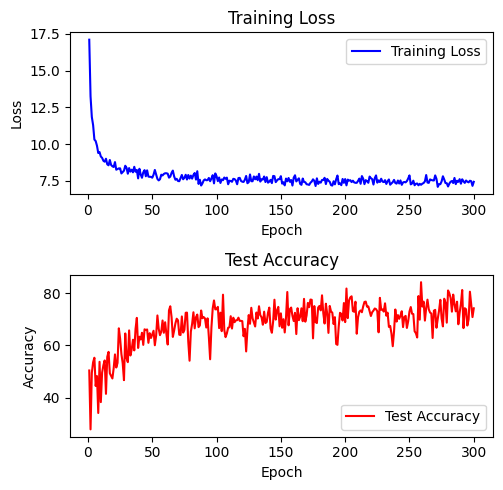

In [43]:
import matplotlib.pyplot as plt

def plot_performance(task_train_losses, task_test_accuracies, name=None):
    """
    Plots the training losses and test accuracies for a given task.

    Parameters:
    - task_train_losses (list): List of training losses for each epoch.
    - task_test_accuracies (list): List of test accuracies for each epoch.
    - name (str): Name to save the plot with. If None, the plot won't be saved.
    """
    epochs = range(1, len(task_train_losses) + 1)

    # Plotting training losses
    plt.figure(figsize=(5, 5))
    plt.subplot(2, 1, 1)
    plt.plot(epochs, task_train_losses, 'b', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting test accuracies
    plt.subplot(2, 1, 2)
    plt.plot(epochs, task_test_accuracies, 'r', label='Test Accuracy')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    
    # Save the plot with the specified name if provided
    if name:
        plt.savefig(f"{name}.png")
    
    plt.show()


plot_performance(task_train_losses, task_test_accuracies, name = 'base training')

In [44]:
# Print the result
print(f"The best accuracy is {best_accuracy:.2f}% at episode number: {best_episode}.")

The best accuracy is 84.29% at episode number: 258.


In [45]:
def consolidate_cluster_means(cluster_means, best_episode):
    if best_episode < 0 or best_episode >= len(cluster_means):
        raise ValueError("best_episode index is out of range")

    # Access the dictionary corresponding to the best episode
    best_episode_dict = cluster_means[best_episode][0]

    return best_episode_dict

In [46]:
#consolidate_cluster_means(cluster_means, best_episode)

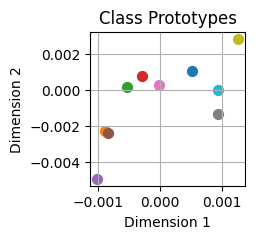

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_cluster_means_tsne(coordinates, figsize=(2, 2), name=None):
    # Convert coordinates to numpy array
    coordinates_array = np.array([coord.detach().numpy() if isinstance(coord, torch.Tensor) else coord for coord in coordinates.values()])

    # Plotting
    fig, ax = plt.subplots(figsize=figsize)  # Specify the figure size
    for i, (label, coord) in enumerate(coordinates.items()):
        if isinstance(coord, torch.Tensor):
            coord = coord.detach().numpy()
        ax.scatter(coord[0], coord[1], label=f'Class {label}', marker='o',s= 50)
        #ax.annotate(f'{label}', (coord[0], coord[1]), textcoords="offset points", xytext=(0.1,0.1), ha='center')

    # Add labels and legend
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_title('Class Prototypes')

    # Remove ticks and labels from the x and y axes
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.xaxis.set_visible(True)
#     ax.yaxis.set_visible(True)
    
    # Add grid lines
    ax.grid(True)

    # Save the plot with the specified name if provided
    if name:
        plt.savefig(f"{name}.png")

    # Show the plot
    plt.show()


plot_cluster_means_tsne(consolidate_cluster_means(cluster_means, best_episode), figsize=(2, 2), name = 'base clusters')

In [48]:
# break

### Finetuning:
1. Load the pre-trained model
2. Create incremental graph streams
3. finetune the model

In [49]:
meta_model = GATmodel(in_channels, hidden_channels, out_channels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
meta_model = meta_model.to(device)

GATConv init.


In [50]:
# Load the saved model
loaded_model = GATmodel(in_channels, hidden_channels, out_channels)
loaded_model.load_state_dict(torch.load('/kaggle/working/meta_model.pth'))
loaded_model = loaded_model.to(device)
print(loaded_model)

GATConv init.
GATmodel(
  (gat_layer_1): GATConv(128, 512, heads=3)
  (gat_layer_2): GATConv(512, 512, heads=3)
)


In [51]:
# Instantiate a new semantic_model
semantic_model_loaded = NeuralNetwork(input_size, hidden_size)
# Load the saved parameters
semantic_model_loaded.load_state_dict(torch.load('semantic_model.pth'))

<All keys matched successfully>

In [52]:
import dgl
import numpy as np

def process_incremental_graphs(graph, num_classes_to_keep, random_seed=None, remaining_classes=None):
    # Fix the random seed
    if random_seed is not None:
        np.random.seed(random_seed)

    # Step 1: Identify the number of classes in the graph
    num_classes = len(np.unique(graph.ndata['label'].numpy()))

    # Step 2: Validate the given number of classes to keep
    if not 0 < num_classes_to_keep <= num_classes:
        raise ValueError("Invalid number of classes to keep.")

    # Step 3: Initialize remaining classes if not provided
    if remaining_classes is None:
        remaining_classes = set(range(num_classes))

    # Step 4: Sample classes without replacement until all classes are exhausted
    if len(remaining_classes) < num_classes_to_keep:
        raise ValueError("Not enough remaining classes to sample.")

    p_classes = np.random.choice(list(remaining_classes), size=num_classes_to_keep, replace=False)


    #print(f"Sampled Classes: {p_classes}")

    # Step 5: Sample nodes corresponding to the specified classes without replacement
    p_nodes = [i for i in range(graph.number_of_nodes()) if graph.ndata['label'][i].item() in p_classes]
    sampled_graph = dgl.node_subgraph(graph, p_nodes)

    # Step 6: Extract node labels and features corresponding to sampled nodes
    sampled_labels = sampled_graph.ndata['label']
    sampled_features = graph.ndata['feat'][p_nodes]  # Replace 'feat' with the actual feature name

    # Step 7: Set the features for the sampled graph
    sampled_graph.ndata['feat'] = sampled_features

    # Step 8: Create a new DGL graph object with sampled features and labels
    new_graph = dgl.graph((sampled_graph.edges()[0], sampled_graph.edges()[1]), num_nodes=sampled_graph.number_of_nodes())
    new_graph.ndata['label'] = sampled_labels
    new_graph.ndata['feat'] = sampled_features  # Replace 'feat' with the actual feature name

    return new_graph, remaining_classes

In [53]:
import random
import numpy as np
import torch
import dgl.data
from collections import OrderedDict

class FineTune_DataGenerator:
    def __init__(self, dataset, num_tasks, num_classes, num_support, num_query, base_classes, novel_classes_list, task_random_seeds, random_seeds, num_walks, walk_length, stream_seed):
        self.dataset = dataset
        self.num_tasks = num_tasks
        self.num_classes = num_classes
        self.num_support = num_support
        self.num_query = num_query
        self.task_random_seeds = task_random_seeds
        self.random_seeds = random_seeds
        self.num_walks = num_walks
        self.walk_length = walk_length
        self.base_classes = base_classes
        self.novel_classes_list = novel_classes_list
        self.stream_seed = stream_seed
        self.task_data = []


    def set_random_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

    def create_task(self, seed, task_random_seeds, base_classes, novel_classes_list):
        tasks_base_unique_classes = []
        tasks_last_k_classes = []
        edge_indices_train_list_base_unique_classes = []
        edge_indices_train_list_last_k_classes = []
        edge_indices_test_list_base_unique_classes = []
        edge_indices_test_list_last_k_classes = []
        support_random_walks_list_base_unique_classes = []
        support_random_walks_list_last_k_classes = []
        query_random_walks_list_base_unique_classes = []
        query_random_walks_list_last_k_classes = []

        for task_seed in task_random_seeds:
            self.set_random_seed(task_seed)
            task_base_unique_classes = {}
            task_last_k_classes = {}
            support_set_last_k_classes = []
            support_set_base_unique_classes = []
            query_set_last_k_classes = []
            query_set_base_unique_classes = []




            for c in base_classes:

                indices = np.where(self.dataset.ndata['label'].numpy() == c)[0]
                support_indices = np.random.choice(indices, size=self.num_support, replace= False)
                query_indices = np.random.choice(indices, size=self.num_query, replace= False)

                support_set_base_unique_classes.extend(support_indices)
                query_set_base_unique_classes.extend(query_indices)

            support_random_walks = self.generate_random_walks(support_set_base_unique_classes)
            support_random_walks_list_base_unique_classes.append(support_random_walks)

            query_random_walks = self.generate_random_walks(query_set_base_unique_classes)
            query_random_walks_list_base_unique_classes.append(query_random_walks)

            # Include query nodes and nodes from query random walks in the 'test' set
            test_set = list(set(query_set_base_unique_classes + [node for walk in query_random_walks for node in walk]))
            task_base_unique_classes['test'] = test_set

            train_set = list(set(support_set_base_unique_classes + [node for walk in support_random_walks for node in walk]))
            task_base_unique_classes['train'] = train_set
            task_base_unique_classes['query_set'] = query_set_base_unique_classes
            task_base_unique_classes['support_set'] = support_set_base_unique_classes
            task_base_unique_classes['seed'] = task_seed

            tasks_base_unique_classes.append(task_base_unique_classes)

            # Generate edge indices for the combined set of query nodes and nodes from query random walks
            edge_indices_test = self.get_edges_from_nodes(test_set)
            edge_indices_train = self.get_edges_from_nodes(train_set)

            edge_indices_test_list_base_unique_classes.append(edge_indices_test)
            edge_indices_train_list_base_unique_classes.append(edge_indices_train)



            for c in novel_classes_list:

                np.random.seed(self.stream_seed)

                indices = np.where(self.dataset.ndata['label'].numpy() == c)[0]
                support_indices = np.random.choice(indices, size=self.num_support, replace= True)
                query_indices = np.random.choice(indices, size=self.num_query, replace= True)

                support_set_last_k_classes.extend(support_indices)
                query_set_last_k_classes.extend(query_indices)

            support_random_walks = self.generate_random_walks(support_set_last_k_classes)
            support_random_walks_list_last_k_classes.append(support_random_walks)

            query_random_walks = self.generate_random_walks(query_set_last_k_classes)
            query_random_walks_list_last_k_classes.append(query_random_walks)

            # Include query nodes and nodes from query random walks in the 'test' set
            test_set = list(set(query_set_last_k_classes + [node for walk in query_random_walks for node in walk]))
            task_last_k_classes['test'] = test_set

            train_set = list(set(support_set_last_k_classes + [node for walk in support_random_walks for node in walk]))
            task_last_k_classes['train'] = train_set
            task_last_k_classes['query_set'] = query_set_last_k_classes
            task_last_k_classes['support_set'] = support_set_last_k_classes
            task_last_k_classes['seed'] = task_seed

            tasks_last_k_classes.append(task_last_k_classes)

            # Generate edge indices for the combined set of query nodes and nodes from query random walks
            edge_indices_test = self.get_edges_from_nodes(test_set)
            edge_indices_train = self.get_edges_from_nodes(train_set)

            edge_indices_test_list_last_k_classes.append(edge_indices_test)
            edge_indices_train_list_last_k_classes.append(edge_indices_train)

        return tasks_last_k_classes, edge_indices_train_list_last_k_classes, edge_indices_test_list_last_k_classes, support_random_walks_list_last_k_classes, query_random_walks_list_last_k_classes, tasks_base_unique_classes, edge_indices_train_list_base_unique_classes, edge_indices_test_list_base_unique_classes, support_random_walks_list_base_unique_classes, query_random_walks_list_base_unique_classes



    def generate_random_walks(self, nodes):
        random_walks = []

        for node in nodes:
            for _ in range(self.num_walks):
                current_node = node
                walk = [current_node]
                for _ in range(self.walk_length - 1):
                    neighbors = list(self.dataset.successors(current_node).numpy())
                    if len(neighbors) > 0:
                        current_node = random.choice(neighbors)
                        walk.append(current_node)
                    else:
                        break
                random_walks.append(walk)

        return random_walks

    def get_edges_from_nodes(self, nodes):
        src, dst = [], []
        for node in nodes:
            successors = list(self.dataset.successors(node).numpy())
            for successor in successors:
                src.append(node)
                dst.append(successor)

        edge_index = torch.stack([torch.tensor(src), torch.tensor(dst)], dim=0).long()
        return edge_index

    def generate_tasks(self):
        tasks_base_unique_classes = []
        tasks_last_k_classes = []
        edge_indices_train_list_base_unique_classes = []
        edge_indices_train_list_last_k_classes = []
        edge_indices_test_list_base_unique_classes = []
        edge_indices_test_list_last_k_classes = []
        support_random_walks_list_base_unique_classes = []
        support_random_walks_list_last_k_classes = []
        query_random_walks_list_base_unique_classes = []
        query_random_walks_list_last_k_classes = []


        for seed in self.random_seeds:
            tasks_data_last_k_classes, edges_train_last_k_classes, edges_test_last_k_classes, support_walks_last_k_classes, query_walks_last_k_classes, tasks_data_base_unique_classes, edges_train_base_unique_classes, edges_test_base_unique_classes, support_walks_base_unique_classes, query_walks_base_unique_classes = self.create_task(seed, self.task_random_seeds, self.base_classes, self.novel_classes_list)
            tasks_base_unique_classes.extend(tasks_data_base_unique_classes)
            tasks_last_k_classes.extend(tasks_data_last_k_classes)
            edge_indices_train_list_base_unique_classes.extend(edges_train_base_unique_classes)
            edge_indices_train_list_last_k_classes.extend(edges_train_last_k_classes)
            edge_indices_test_list_base_unique_classes.extend(edges_test_base_unique_classes)
            edge_indices_test_list_last_k_classes.extend(edges_test_last_k_classes)
            support_random_walks_list_base_unique_classes.extend(support_walks_base_unique_classes)
            support_random_walks_list_last_k_classes.extend(support_walks_last_k_classes)
            query_random_walks_list_base_unique_classes.extend(query_walks_base_unique_classes)
            query_random_walks_list_last_k_classes.extend(query_walks_last_k_classes)


        return tasks_base_unique_classes, tasks_last_k_classes , edge_indices_train_list_base_unique_classes, edge_indices_train_list_last_k_classes, edge_indices_test_list_base_unique_classes, edge_indices_test_list_last_k_classes, support_random_walks_list_base_unique_classes, support_random_walks_list_last_k_classes, query_random_walks_list_base_unique_classes, query_random_walks_list_last_k_classes


## semantics for zero shot

In [54]:
base_remaining_classes = set(range(len(np.unique(Original_graph.ndata['label'].numpy()))))  # Start with all classes

sampled_graph_base, _ = process_incremental_graphs(
    Original_graph,
    num_classes_to_keep= 13,
    random_seed = 42,
    remaining_classes=base_remaining_classes
)
get_unique_classes(sampled_graph_base)

[4, 37, 6, 39, 9, 12, 13, 15, 16, 19, 25, 26, 27]

trial

In [55]:
import torch
import random

def semantic_data_generator(train_features, train_labels, novel_classes_list, num_zero_shot, novel_classes, total_zero, semantic_features_dict=None, seed=None):
    # Set the random seed for reproducibility
    if seed is not None:
        torch.manual_seed(seed)
        random.seed(seed)

    zero_shot_classes = num_zero_shot
    total_zero.extend(zero_shot_classes)
    
    # Identify the indices of rows corresponding to zero-shot classes
    zero_shot_indices = [i for i, label in enumerate(train_labels) if label.item() in total_zero]

    # If semantic features are provided, use them; otherwise, use a tensor of zeros
    if semantic_features_dict is not None:
        zero_tensor = torch.zeros_like(train_features)
        for label, features in semantic_features_dict.items():
            if label in novel_classes_list:  # Check if the label is in the total_zero list
                label_index = novel_classes_list.index(label)
                zero_tensor[train_labels == label_index, :] = features
    else:
        zero_tensor = torch.zeros_like(train_features)

    # Replace the rows corresponding to zero-shot classes with the zero tensor
    new_train_features = train_features.clone()
    new_train_features[zero_shot_indices, :] = zero_tensor[zero_shot_indices, :]

    return new_train_features, train_labels, total_zero

# # Example usage
# # Assuming train_features, train_labels, novel_classes_list, num_zero_shot, and semantic_features_dict are defined
# train_features = torch.randn((10, 2))  # Replace with actual size
# train_labels = torch.randint(0, 10, (10,))  # Replace with actual size and class labels
# novel_classes_list = [0, 1, 2, 3, 4]
# num_zero_shot = 1
# semantic_features_dict = {0: torch.zeros((2,)),
#                           1: torch.zeros((2,)), 
#                           2: torch.zeros((2,)), 
#                           3: torch.ones((2,)), 
#                           4: torch.zeros((2,)),
#                           5: torch.zeros((2,)),
#                           6: torch.zeros((2,)),
#                           7: torch.ones((2,)),
#                           8: torch.zeros((2,)),
#                           9: torch.zeros((2,))}
# random_seed = 42  # Replace with any integer value

# novel_classes = [5, 6, 7, 8, 9]
# total_zero = []

# new_train_features, train_labels, total_zero = semantic_data_generator(train_features, train_labels, novel_classes_list, num_zero_shot, semantic_features_dict=semantic_features_dict, seed=random_seed, novel_classes=novel_classes, total_zero=total_zero)

# print("New Train Features Shape:\n", new_train_features)
# print("Train Labels:", train_labels)
# print("Total Zero Shot Classes:", total_zero)

# novel_classes = [3, 5, 1, 0, 2]
# new_train_features, train_labels, total_zero = semantic_data_generator(train_features, train_labels, novel_classes_list, num_zero_shot, semantic_features_dict=semantic_features_dict, seed=random_seed, novel_classes=novel_classes, total_zero=total_zero)

# print("New Train Features Shape:\n", new_train_features)
# print("Train Labels:", train_labels)
# print("Total Zero Shot Classes:", total_zero)

In [56]:
import torch
from torch_geometric.data import Data
import numpy as np

def create_context_and_datasets(graph, num_classes, num_support, num_query, base_classes, novel_classes_list, stream_seed, start_seed, spacing, num_seeds, num_zero_shot, novel_classes, total_zero, semantic_features_dict):
    # Your existing code for generating random seeds
    task_random_seeds = [start_seed + i * spacing for i in range(num_seeds)]
    random_seeds = [42]
    num_tasks = num_seeds

    # Your existing code for generating tasks and extracting features
    metadata_generator = FineTune_DataGenerator(graph, num_tasks, num_classes, num_support, num_query, base_classes, novel_classes_list, task_random_seeds, random_seeds, 10, 3,  stream_seed)
    tasks_base_unique_classes, tasks_last_k_classes, edge_indices_train_list_base_unique_classes, edge_indices_train_list_last_k_classes, edge_indices_test_list_base_unique_classes, edge_indices_test_list_last_k_classes, support_random_walks_list_base_unique_classes, support_random_walks_list_last_k_classes, query_random_walks_list_base_unique_classes, query_random_walks_list_last_k_classes = metadata_generator.generate_tasks()

    # Your existing code for combining tasks
    combined_query_random_walks_list = [
        query_base + query_last_k
        for query_base, query_last_k in zip(query_random_walks_list_base_unique_classes, query_random_walks_list_last_k_classes)
    ]

    # Your existing code for combining edge indices
    combined_edge_indices_train_list = [
        torch.cat([edge_base, edge_last_k], dim=1)
        for edge_base, edge_last_k in zip(edge_indices_train_list_base_unique_classes, edge_indices_train_list_last_k_classes)
    ]

    combined_edge_indices_test_list = [
        torch.cat([edge_base, edge_last_k], dim=1)
        for edge_base, edge_last_k in zip(edge_indices_test_list_base_unique_classes, edge_indices_test_list_last_k_classes)
    ]

    # Your existing code for combining support random walks
    combined_support_random_walks_list = [
        support_base + support_last_k
        for support_base, support_last_k in zip(support_random_walks_list_base_unique_classes, support_random_walks_list_last_k_classes)
    ]

    combined_tasks = []
    for base_task, last_k_task in zip(tasks_base_unique_classes, tasks_last_k_classes):
        combined_task = {
            'test': base_task['test'] + last_k_task['test'],
            'train': base_task['train'] + last_k_task['train'],
            'query_set': base_task['query_set'] + last_k_task['query_set'],
            'support_set': base_task['support_set'] + last_k_task['support_set'],
            'seed': base_task['seed'],  # You may want to choose which seed to use
        }
        combined_tasks.append(combined_task)

    train_set_list = []
    test_set_list = []
    context_dictionary_list = []
    task_datasets_euc = []

    for i, task in enumerate(combined_tasks):
        #print(f"Episodes: {i} - Seed: {task['seed']}, streaming seed = {stream_seed}")
        seed = tasks_last_k_classes[i]['seed']
        extractor = create_feature_label_extractor(graph, combined_tasks)
        train_features, train_labels, test_features, test_labels, support_features, support_labels, query_features, query_labels, train_degrees, test_degrees, support_degrees, query_degrees = extractor(i, seed)

        train_features, train_labels, total_zero = semantic_data_generator(train_features, train_labels, novel_classes_list, num_zero_shot, novel_classes, total_zero, semantic_features_dict=None, seed=None)
        
        train_set_list.append(task['train'])
        test_set_list.append(task['test'])

        reindexed_train_set, reindexed_edge_indices_train, reindexed_random_walks_train, old_to_new_mapping_train = reindex_nodes(i, train_set_list, combined_edge_indices_train_list, combined_support_random_walks_list)
        reindexed_test_set, reindexed_edge_indices_test, reindexed_random_walks_test, old_to_new_mapping_test = reindex_nodes(i, test_set_list, combined_edge_indices_test_list, combined_query_random_walks_list)

        data_train_euc = Data(x=train_features, edge_index=reindexed_edge_indices_train, y=train_labels)
        data_test_euc = Data(x=test_features, edge_index=reindexed_edge_indices_test, y=test_labels)
        task_datasets_euc.append((data_train_euc, data_test_euc))

        labels_for_nodes, remaining_nodes, original_first_node_list, all_firsts = dict_for_custom_loss_function(reindexed_random_walks_train, old_to_new_mapping_train, graph)

        result_label_dict = create_label_dict(labels_for_nodes, remaining_nodes, all_firsts)

        unique_elements_result = get_unique_elements_in_order(all_firsts)

        unique_elements_result = np.array(unique_elements_result).reshape(num_classes, num_support)
        # Add elements to the reformulated dictionary
        add_elements_to_dictionary_list(result_label_dict, unique_elements_result)
        # Print the reformulated dictionary after adding elements
        context_dictionary_list.append(result_label_dict)

    return context_dictionary_list, task_datasets_euc, total_zero


In [57]:
def get_unique_classes(graph):
    """
    Extracts unique class labels from the 'label' attribute of a graph's node data.

    Parameters:
    - graph: The input graph.

    Returns:
    - list_of_classes: A list of unique class labels.
    """
    try:
        # Assuming 'label' is a tensor or NumPy array
        class_labels = graph.ndata['label'].numpy()
    except KeyError:
        # Adjust the key if the attribute name is different
        print("Error: 'label' attribute not found in node data.")
        return []

    # Extract unique class labels
    unique_classes = set(class_labels)

    # Convert the set to a list (order not guaranteed)
    list_of_classes = list(unique_classes)

    return list_of_classes

In [58]:
base_remaining_classes = set(range(len(np.unique(Original_graph.ndata['label'].numpy()))))  # Start with all classes

sampled_graph_base, _ = process_incremental_graphs(
    Original_graph,
    num_classes_to_keep= 13,
    random_seed=42,
    remaining_classes=base_remaining_classes
)
get_unique_classes(sampled_graph_base)

[4, 37, 6, 39, 9, 12, 13, 15, 16, 19, 25, 26, 27]

In [59]:
def reorder_dictionary(class_dict, base_classes, novel_classes, zero_shot_classes):
    reordered_dict = {}

    # First, add all classes except zero-shot classes
    for label in sorted(class_dict.keys()):
        if label not in zero_shot_classes:
            reordered_dict[label] = class_dict[label]

    # Then, add zero-shot classes
    for label in sorted(zero_shot_classes):
        reordered_dict[label] = class_dict[label]

    return reordered_dict

def reorder_dictionary_list(dictionary_list, base_classes, novel_classes, zero_shot_classes):
    reordered_list = []
    
    # Iterate over each dictionary in the list
    for class_dict in dictionary_list:
        # Call reorder_dictionary function to reorder the dictionary
        reordered_dict = reorder_dictionary(class_dict, base_classes, novel_classes, zero_shot_classes)
        # Append the reordered dictionary to the list
        reordered_list.append(reordered_dict)
    
    return reordered_list

new loss update

In [60]:
# import torch

# def Lintra_loss_fine(embeddings, context_dictionary, target_radius, semantic_vectors):
#     loss_intra = 0
#     num_clusters = len(context_dictionary)

#     # Calculate mean vectors for each cluster
#     mean_vectors = {j: torch.mean(embeddings[cluster_elements], dim=0) for j, cluster_elements in context_dictionary.items()}
#     mean_vectors = create_new_proto(mean_vectors, semantic_vectors)
    
#     # Calculate intra-cluster loss
#     for j, cluster_elements in context_dictionary.items():
#         mean_vector = mean_vectors[j]
        
#         # Check if j is in total_zero list
#         if j in total_zero:
#             print(j)
#             # If j is in total_zero, set loss_intra to 0 and continue with the next cluster
#             loss_intra = 0
#             continue

#         for i in cluster_elements:
#             embedding_i = embeddings[i]
#             norm_diff = torch.norm(embedding_i - mean_vector)
#             loss_contrib = torch.clamp(norm_diff - target_radius, min=0)

#             # Calculate the sum of all d_{ij} within the cluster
#             sum_dij = torch.sum(torch.clamp(torch.norm(embeddings[cluster_elements] - mean_vector, dim=1) - target_radius, min=0))

#             # Normalize dij by the sum of all dij within the cluster
#             normalized_dij = loss_contrib 

#             # Add the normalized contribution to the overall loss
#             loss_intra += normalized_dij
            
#     # Normalize the overall loss by the number of clusters
#     loss_intra_normalized = loss_intra / num_clusters
#     return loss_intra_normalized, mean_vectors


### We change the intra and inter loss functions, for the GOTHAM III.o framework

In [61]:
import torch

def Lintra_loss_fine(embeddings, context_dictionary, target_radius, semantic_vectors, total_zero):
    loss_intra = 0
    num_clusters = len(context_dictionary)
    mean_vectors = {}

    # Calculate mean vectors for each cluster
    for j, cluster_elements in context_dictionary.items():
        if j in total_zero:
            # Calculate mean vectors using torch.mean() if j is in total_zero
            mean_vectors[j] = torch.mean(embeddings[cluster_elements], dim=0)
        else:
            # Calculate mean vectors using create_new_proto() if j is not in total_zero
            mean_vectors[j] = torch.mean(embeddings[cluster_elements], dim=0)
            mean_vectors = create_new_proto(mean_vectors, semantic_vectors)

    # Calculate intra-cluster loss
    for j, cluster_elements in context_dictionary.items():
        mean_vector = mean_vectors[j]
        
        if j in total_zero:
            continue  # Skip calculation if j is in total_zero
        
        for i in cluster_elements:
            embedding_i = embeddings[i]
            norm_diff = torch.norm(embedding_i - mean_vector)
            loss_contrib = torch.clamp(norm_diff - target_radius, min=0)

            # Calculate the sum of all d_{ij} within the cluster
            sum_dij = torch.sum(torch.clamp(torch.norm(embeddings[cluster_elements] - mean_vector, dim=1) - target_radius, min=0))

            # Avoid division by zero
            if sum_dij > 0:
                # Normalize dij by the sum of all dij within the cluster
                normalized_dij = loss_contrib 

                # Add the normalized contribution to the overall loss
                loss_intra += normalized_dij
            
    # Normalize the overall loss by the number of clusters
    loss_intra_normalized = loss_intra / num_clusters
    return loss_intra_normalized, mean_vectors


don't delete this

In [62]:
# import torch

# def Linter_loss_fine(embeddings, context_dictionary, semantic_vectors, total_zero):
#     mean_vectors = {j: torch.mean(embeddings[cluster_elements], dim=0) for j, cluster_elements in context_dictionary.items()}
#     mean_vectors = create_new_proto(mean_vectors, semantic_vectors)
#     loss_inter = 0
#     num_clusters = len(context_dictionary)

#     for j, cluster_j in context_dictionary.items():
#         for p, cluster_p in context_dictionary.items():
#             if p != j and j in mean_vectors and p in mean_vectors:  # Check if keys exist
#                 norm_diff = -torch.log(torch.norm(mean_vectors[j] - mean_vectors[p]) )
#                 loss_inter += norm_diff
#     loss_inter_normalised = loss_inter / num_clusters
#     return loss_inter_normalised, mean_vectors

In [63]:
import torch

def Linter_loss_fine(embeddings, context_dictionary, semantic_vectors, total_zero):
    loss_inter = 0
    num_clusters = len(context_dictionary)
    mean_vectors = {}
    
    # Calculate mean vectors for each cluster
    for j, cluster_elements in context_dictionary.items():
        if j in total_zero:
            # Calculate mean vectors using torch.mean() if j is in total_zero
            mean_vectors[j] = torch.mean(embeddings[cluster_elements], dim=0)
        else:
            # Calculate mean vectors using create_new_proto() if j is not in total_zero
            mean_vectors[j] = torch.mean(embeddings[cluster_elements], dim=0)
            mean_vectors = create_new_proto(mean_vectors, semantic_vectors)
            
    

    for j, cluster_j in context_dictionary.items():
        for p, cluster_p in context_dictionary.items():
            if p != j and j in mean_vectors and p in mean_vectors:  # Check if keys exist
                norm_diff = -torch.log(torch.norm(mean_vectors[j] - mean_vectors[p]) )
                loss_inter += norm_diff
    loss_inter_normalised = loss_inter / num_clusters
    return loss_inter_normalised, mean_vectors


In [64]:
import torch

def KDloss(teacher_train_output, semantic_output_teacher, train_output, semantic_output, novel_classes, train_label, total_zero):
    
    novel_classes = [cls for cls in novel_classes if cls not in total_zero]
    
    # Convert novel_classes to a tensor for comparison
    novel_classes_tensor = torch.tensor(novel_classes)

    # Find indices of rows in train_label corresponding to novel_classes
    novel_indices = torch.where(torch.isin(train_label, novel_classes_tensor))[0]

    # Create a boolean mask for filtering
    mask = torch.ones(len(train_label), dtype=torch.bool)
    mask[novel_indices] = False

    # Filter out the corresponding rows from teacher_train_output and train_output
    teacher_train_output_filtered = teacher_train_output[mask]
    train_output_filtered = train_output[mask]

    # Remove key-value pairs from semantic_output_teacher and semantic_output for novel classes
    for label in novel_classes:
        if label in semantic_output_teacher:
            del semantic_output_teacher[label]
        if label in semantic_output:
            del semantic_output[label]

    # Match and update semantic embeddings for common classes
    teacher_sem = []
    student_sem = []

    for label in semantic_output_teacher.keys():
        if label in semantic_output:
            # Concatenate semantic embeddings for the same class label
            teacher_sem.append(semantic_output_teacher[label])
            student_sem.append(semantic_output[label])

    # Stack the lists of embeddings along a new axis to create tensors
    teacher_sem = torch.stack(teacher_sem)
    student_sem = torch.stack(student_sem)

    # Now both the teacher and student for both node alignment and semantic alignment contain only those labels
    # from the previous stream

    # Node alignment loss
    squared_distance = torch.sum((torch.exp(teacher_train_output_filtered) - torch.exp(train_output_filtered)) ** 1, dim=1)
    # Average over samples
    N = teacher_train_output_filtered.size(0)
    node_loss = torch.mean(squared_distance) / N

    # Semantic alignment loss
    dot_product = torch.sum(teacher_sem * student_sem, dim=1)
    # Calculate norms
    teacher_norm = torch.norm(teacher_sem, dim=1)
    student_norm = torch.norm(student_sem, dim=1)
    # Calculate loss term
    loss_term = 1 - dot_product / (teacher_norm * student_norm)
    # Average over classes
    C = teacher_sem.size(0)
    semantic_alignment_loss = torch.mean(loss_term) / C

    return node_loss, semantic_alignment_loss


In [65]:
from collections import Counter

def fine_tune(teacher_model, teacher_model_semantic, novel_classes, meta_model, semantic_model, task_datasets, ft_lr, weight_decays, context_dictionary_list, semantic_vectors, total_zero):
    optimizer_meta = optim.Adam(meta_model.parameters(), lr=meta_lr, weight_decay=weight_decays)
    optimizer_semantic = optim.Adam(semantic_model.parameters(), lr=0.01, weight_decay=weight_decays)

    total_losses = []  # List to store total losses over meta-epochs
    task_train_losses = []  # List to store task train losses over meta-epochs
    task_test_losses = [[] for _ in range(len(task_datasets))]  # List to store task test losses over meta-epochs
    task_train_accuracies = [[] for _ in range(len(task_datasets))]  # List to store task train accuracies over meta-epochs
    task_test_accuracies = []  # List to store task test accuracies 
    task_cluster_means = [[] for _ in range(len(task_datasets))]  # List to store task means over episodes
    all_train_data = []
    task_dictionary = {}

     

    # Inner loop (tasks)
    for i, task_data in enumerate(task_datasets):
        task_train_data, task_test_data = task_data

        all_train_data.append(task_train_data)
        
        # teacher model will be in evaluation mode
        teacher_model.eval()
        teacher_model_semantic.eval()
        semantic_output_teacher = {}
        for label, embed in semantic_vectors.items():
            output_teacher = teacher_model_semantic(embed).squeeze()
            semantic_output_teacher[label] = output_teacher
        
        #print(f'teacher: {semantic_output_teacher}')
        
        teacher_train_output = teacher_model(task_train_data.x, task_train_data.edge_index)
        #print(f'teacher train: {teacher_train_output}')
 
        
        # Training phase
        meta_model.train()
        semantic_model.train()  # Set the semantic model to training mode
        optimizer_meta.zero_grad()
        optimizer_semantic.zero_grad()
        
        # meta_model is the student model, student model will be in training phase
        train_output = meta_model(task_train_data.x, task_train_data.edge_index)  # Embeddings (train)
        #print(f'student train: {train_output}')
        
        train_label = task_train_data.y
        loss_intra, _ = Lintra_loss_fine(train_output, context_dictionary_list[i], 0.01, semantic_vectors, total_zero)
        loss_inter, mean_vectors = Linter_loss_fine(train_output, context_dictionary_list[i], semantic_vectors, total_zero)

        # Semantic model forward pass
        semantic_output = {}
        for label, embed in semantic_vectors.items():
            output = semantic_model(embed).squeeze()
            semantic_output[label] = output

            


        # Calculate semantic loss
        semantic_loss_proto, semantic_output, semantic_embeddings_dict = L_proto(mean_vectors, semantic_output)
        
        #print(f'student: {semantic_embeddings_dict}')
             
        
        # Calculate the knowledge distillation loss
        node_loss, semantic_alignment_loss = KDloss(teacher_train_output, semantic_output_teacher, train_output, semantic_embeddings_dict, novel_classes, train_label, total_zero)
        

        # Backpropagate through semantic model
        
        semantic_loss = semantic_loss_proto + semantic_alignment_loss
        #print(f'node loss: {node_loss} and semantic loss: {semantic_alignment_loss}')
        #semantic_loss = semantic_loss_proto 
        semantic_loss.backward(retain_graph=True)  # Specify retain_graph=True
        optimizer_semantic.step()
        
        loss = 1 * loss_intra + 0.25 * loss_inter + node_loss
        
        #loss = 1 * loss_intra + 0.25 * loss_inter 
        loss.backward()
        optimizer_meta.step()
        

        # Validation phase
        meta_model.eval()  # Set the model to evaluation mode
        test_output = meta_model(task_test_data.x, task_test_data.edge_index)
        test_acc = accuracy_cosine(test_output, task_test_data.y, mean_vectors) * 100
        task_dictionary[i] = test_acc
        # Append metrics to lists
        task_cluster_means[i].append(mean_vectors)
        task_train_losses.append(loss.item())
        task_test_accuracies.append(test_acc)

        print(f'task = {i}, loss = {loss.item():.2f}, loss_semantic = {semantic_loss.item():.2f}, test acc = {test_acc:.2f}%')


    # Return  meta-model, task cluster means and task dictionary
    return  meta_model, semantic_model, task_cluster_means, task_dictionary, task_train_losses, task_test_accuracies

### Semantic Dictionary

semantic graph

In [66]:
base_remaining_classes = set(range(len(np.unique(Original_graph.ndata['label'].numpy()))))  # Start with all classes

sampled_graph_base, _ = process_incremental_graphs(
    Original_graph,
    num_classes_to_keep= 13,
    random_seed=42,
    remaining_classes=base_remaining_classes
)
get_unique_classes(sampled_graph_base)

[4, 37, 6, 39, 9, 12, 13, 15, 16, 19, 25, 26, 27]

Number of Classes (Base) = 10, Base classes are: [4, 37, 6, 39, 12, 15, 16, 19, 26, 27]
========================== Streaming session: 1 ==========================
Number of Classes (Base + Novel) = 13
Novel classes are: [9, 13, 25]
Base Classes: [4, 37, 6, 39, 12, 15, 16, 19, 26, 27]
Total Novel Classes List: [9, 13, 25]
zero-shot classes: [9, 13, 25]
task = 0, loss = 11.17, loss_semantic = 0.18, test acc = 43.64%
task = 1, loss = 10.90, loss_semantic = 2.99, test acc = 24.88%
task = 2, loss = 10.88, loss_semantic = 1.32, test acc = 28.98%
task = 3, loss = 10.60, loss_semantic = 1.46, test acc = 29.63%
task = 4, loss = 10.33, loss_semantic = 1.84, test acc = 42.29%
task = 5, loss = 10.55, loss_semantic = 1.41, test acc = 26.41%
task = 6, loss = 10.07, loss_semantic = 0.79, test acc = 25.04%
task = 7, loss = 10.05, loss_semantic = 0.94, test acc = 24.80%
task = 8, loss = 9.81, loss_semantic = 1.08, test acc = 38.31%
task = 9, loss = 9.68, loss_semantic = 0.94, test acc = 44.24%
task = 1

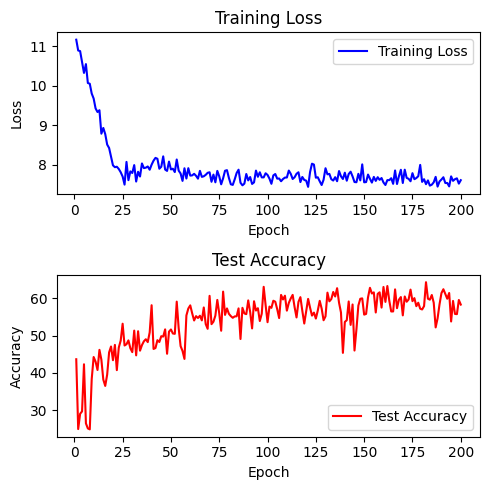

The best accuracy is 64.35% at episode number 181.
========================== Streaming session: 2 ==========================
Number of Classes (Base + Novel) = 16
Novel classes are: [8, 34, 31]
Base Classes: [4, 37, 6, 39, 12, 15, 16, 19, 26, 27]
Total Novel Classes List: [9, 13, 25, 8, 34, 31]
zero-shot classes: [34, 8, 9, 13, 25, 31]
task = 0, loss = 8.09, loss_semantic = 1.81, test acc = 41.65%
task = 1, loss = 9.11, loss_semantic = 3.96, test acc = 43.02%
task = 2, loss = 8.49, loss_semantic = 2.72, test acc = 44.67%
task = 3, loss = 8.21, loss_semantic = 2.67, test acc = 26.44%
task = 4, loss = 8.16, loss_semantic = 2.91, test acc = 29.27%
task = 5, loss = 8.01, loss_semantic = 2.80, test acc = 40.42%
task = 6, loss = 7.84, loss_semantic = 2.56, test acc = 46.11%
task = 7, loss = 7.87, loss_semantic = 2.60, test acc = 47.72%
task = 8, loss = 7.97, loss_semantic = 2.56, test acc = 42.45%
task = 9, loss = 8.13, loss_semantic = 2.23, test acc = 51.34%
task = 10, loss = 7.89, loss_se

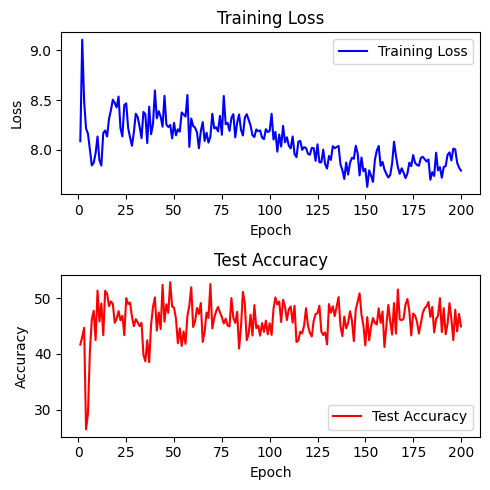

The best accuracy is 52.85% at episode number 47.
========================== Streaming session: 3 ==========================
Number of Classes (Base + Novel) = 19
Novel classes are: [0, 17, 24]
Base Classes: [4, 37, 6, 39, 12, 15, 16, 19, 26, 27]
Total Novel Classes List: [9, 13, 25, 8, 34, 31, 0, 17, 24]
zero-shot classes: [0, 34, 8, 9, 13, 17, 24, 25, 31]
task = 0, loss = 8.63, loss_semantic = 2.32, test acc = 31.76%
task = 1, loss = 9.48, loss_semantic = 5.01, test acc = 34.79%
task = 2, loss = 8.98, loss_semantic = 3.08, test acc = 27.32%
task = 3, loss = 8.91, loss_semantic = 3.03, test acc = 25.76%
task = 4, loss = 8.66, loss_semantic = 3.71, test acc = 29.15%
task = 5, loss = 8.08, loss_semantic = 3.82, test acc = 37.23%
task = 6, loss = 8.16, loss_semantic = 3.46, test acc = 36.91%
task = 7, loss = 8.17, loss_semantic = 3.43, test acc = 36.19%
task = 8, loss = 8.05, loss_semantic = 3.48, test acc = 36.86%
task = 9, loss = 8.06, loss_semantic = 3.38, test acc = 36.91%
task = 10,

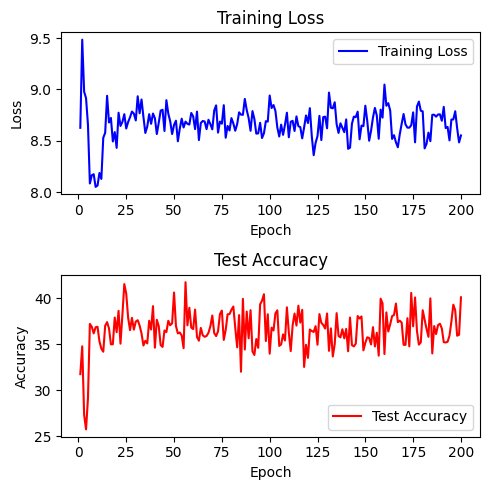

The best accuracy is 41.76% at episode number 55.
========================== Streaming session: 4 ==========================
Number of Classes (Base + Novel) = 22
Novel classes are: [33, 11, 5]
Base Classes: [4, 37, 6, 39, 12, 15, 16, 19, 26, 27]
Total Novel Classes List: [9, 13, 25, 8, 34, 31, 0, 17, 24, 33, 11, 5]
zero-shot classes: [0, 33, 34, 5, 8, 9, 11, 13, 17, 24, 25, 31]
task = 0, loss = 10.06, loss_semantic = 2.10, test acc = 17.84%
task = 1, loss = 9.69, loss_semantic = 6.62, test acc = 29.08%
task = 2, loss = 9.49, loss_semantic = 3.59, test acc = 29.74%
task = 3, loss = 9.61, loss_semantic = 4.53, test acc = 33.22%
task = 4, loss = 9.42, loss_semantic = 4.91, test acc = 32.90%
task = 5, loss = 9.35, loss_semantic = 4.28, test acc = 32.11%
task = 6, loss = 8.98, loss_semantic = 3.82, test acc = 28.64%
task = 7, loss = 8.86, loss_semantic = 4.14, test acc = 17.88%
task = 8, loss = 9.04, loss_semantic = 4.56, test acc = 19.10%
task = 9, loss = 8.88, loss_semantic = 4.33, test 

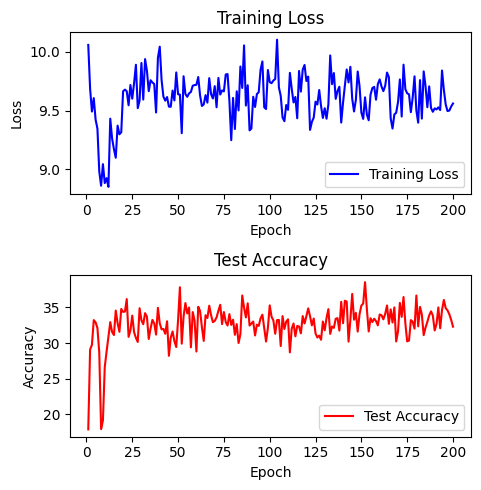

The best accuracy is 38.56% at episode number 151.
========================== Streaming session: 5 ==========================
Number of Classes (Base + Novel) = 25
Novel classes are: [1, 29, 21]
Base Classes: [4, 37, 6, 39, 12, 15, 16, 19, 26, 27]
Total Novel Classes List: [9, 13, 25, 8, 34, 31, 0, 17, 24, 33, 11, 5, 1, 29, 21]
zero-shot classes: [0, 33, 34, 1, 5, 8, 9, 11, 13, 17, 21, 24, 25, 29, 31]
task = 0, loss = 10.92, loss_semantic = 2.70, test acc = 11.73%
task = 1, loss = 10.25, loss_semantic = 7.92, test acc = 27.30%
task = 2, loss = 10.34, loss_semantic = 4.32, test acc = 27.76%
task = 3, loss = 10.30, loss_semantic = 5.07, test acc = 29.26%
task = 4, loss = 10.45, loss_semantic = 5.63, test acc = 28.30%
task = 5, loss = 10.16, loss_semantic = 4.75, test acc = 26.52%
task = 6, loss = 10.20, loss_semantic = 4.12, test acc = 21.42%
task = 7, loss = 9.80, loss_semantic = 4.81, test acc = 16.62%
task = 8, loss = 9.86, loss_semantic = 5.05, test acc = 22.52%
task = 9, loss = 9.58

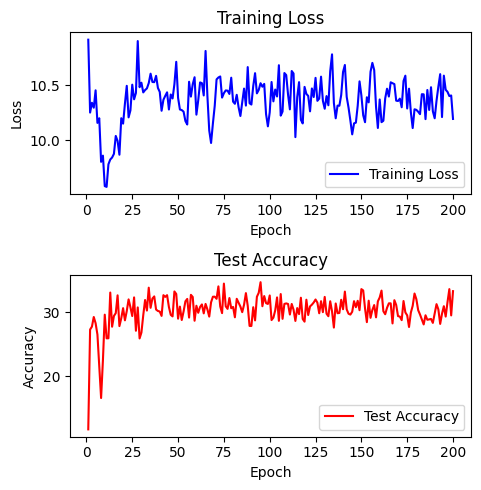

The best accuracy is 34.69% at episode number 94.
========================== Streaming session: 6 ==========================
Number of Classes (Base + Novel) = 28
Novel classes are: [2, 36, 30]
Base Classes: [4, 37, 6, 39, 12, 15, 16, 19, 26, 27]
Total Novel Classes List: [9, 13, 25, 8, 34, 31, 0, 17, 24, 33, 11, 5, 1, 29, 21, 2, 36, 30]


ValueError: cannot reshape array of size 278 into shape (28,10)

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time
streaming_seeds = [52, 46, 11, 24, 52, 70, 66, 41, 162, 1110]
starting_seeds = [425, 310, 20,180, 535, 110, 195, 233, 541, 945]

semantic_vectors = semantic_embeddings


previous_classes = set()  # Initialize an empty set outside the loop
base_classes_list = []    # Initialize an empty list for base classes
novel_classes_list = []   # Initialize an empty list for novel classes
total_zero = []
p = 0

start_time = time.time()  # Record start time
for i in range(10, 43, 3):

    sampled_graph_base, _ = process_incremental_graphs(
        graph_arxiv,
        num_classes_to_keep=i,
        random_seed = 42,
        remaining_classes=base_remaining_classes
    )

    all_classes = get_unique_classes(sampled_graph_base)

    if i == 10 :
        base_classes = list(set(all_classes))
        base_classes_list.extend(all_classes)  # Append base classes to the list
        print(f'Number of Classes (Base) = {i}, Base classes are: {base_classes}')
    else:
        print(f"========================== Streaming session: {p+1} ==========================")
        print(f'Number of Classes (Base + Novel) = {i}')
        novel_classes = list(set(all_classes) - previous_classes)
        novel_classes_list.extend(novel_classes)  # Append novel classes to the list
        print(f'Novel classes are: {novel_classes}')
        stream_seed = streaming_seeds[p]
        start_seed = starting_seeds[p]
        p += 1

        # Print the total novel classes list at each step only for i > 20
        print(f'Base Classes: {base_classes}')
        print(f'Total Novel Classes List: {novel_classes_list}')

        num_classes = i
        num_support = 10
        num_query = 10
        spacing = 50
        num_seeds = 200   #number of episodes in each stream
        ft_lr = 0.001
        num_zero_shot = 3
        num_zero_shot = random.sample(novel_classes, num_zero_shot)


#         context_dictionary_list, task_datasets_euc = create_context_and_datasets(graph_arxiv, num_classes, num_support, num_query, base_classes, novel_classes_list, stream_seed, start_seed, spacing, num_seeds)
        context_dictionary_list, task_datasets_euc, total_zero = create_context_and_datasets(sampled_graph_base, num_classes, num_support, num_query, base_classes, novel_classes_list, stream_seed, start_seed, spacing, num_seeds, num_zero_shot, novel_classes, total_zero, semantic_vectors)
       
        complete_zeroshot_classes = list(set(total_zero))
        print(f'zero-shot classes: {list(set(total_zero))}')
        
        context_dictionary_list = reorder_dictionary_list(context_dictionary_list, base_classes, novel_classes_list, complete_zeroshot_classes)

        # Train the meta-learning model with regularization
        teacher_model = loaded_model
        teacher_model_semantic = semantic_model_loaded
        current_model, semantic_model_current, cluster_means, task_dictionary, task_train_losses, task_test_accuracies = fine_tune(teacher_model, teacher_model_semantic, novel_classes, loaded_model, semantic_model_loaded, task_datasets_euc, ft_lr, weight_decays, context_dictionary_list, semantic_vectors, total_zero)
        loaded_model = current_model
        loaded_model_semantic = semantic_model_current

        # Find the episode number and corresponding accuracy with the highest accuracy
        best_episode = max(task_dictionary, key=task_dictionary.get)
        best_accuracy = task_dictionary[best_episode]
        
        # Save the model after each streaming session
        model_name = f'streaming_model_{p}.pt'
        torch.save(model.state_dict(), model_name)
        print(f'Model saved as: {model_name}')
        
        
        
        # Print the result
        plot_performance(task_train_losses, task_test_accuracies)
        print(f"The best accuracy is {best_accuracy:.2f}% at episode number {best_episode}.")
#         plot_cluster_means_tsne(consolidate_cluster_means(cluster_means, best_episode))
#         # Save the plot as an image
#         plot_name = f'streaming_plot_{p}.png'
#         plt.savefig(plot_name)
#         print(f'Plot saved as: {plot_name}')
        plt.close()  # Close the current plot to avoid overlapping with the next iteration
        

    previous_classes = set(all_classes)
end_time = time.time()  # Record end time
execution_time = end_time - start_time
print(f"Total execution time: {execution_time} seconds.")